*****************************************************************************************************************************************************
*****************************************************************************************************************************************************

**Task 2 — Text Classification with Keras**
</br>
This task is designed to get you familiar with text classification pipeline in Keras & Tensorflow. You will chose one of the provided text classification datasets and then create deep learning model. This task focuses on models based on word embeddings.

(a) Choose one of the following datasets:</br>
    &nbsp;&nbsp;&nbsp;&nbsp;a) Emotion - Dataset for emotion classification</br>
    &nbsp;&nbsp;&nbsp;&nbsp;b) DBpedia14 - Dataset for ontology classification</br>
    &nbsp;&nbsp;&nbsp;&nbsp;c) The Multilingual Amazon Reviews Corpus - dataset for classifying product reviews (English language subset)

In [1]:
# load the emotion dataset (dair-ai/emotion) from HuggingFace
from datasets import load_dataset

# load the train and val from the emotion dataset
emotion_dataset = load_dataset('dair-ai/emotion')

# print the first 5 examples
emotion_dataset['train'][:5]

No config specified, defaulting to: emotion/split
Reusing dataset emotion (/home/nishan/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

(b) Explore the dataset and choose appropriate text preprocessing steps.

In [2]:
emotion_dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [3]:
# size of the training and vaöidation set
len(emotion_dataset['train']), len(emotion_dataset['validation'])

(16000, 2000)

In [4]:
emotion_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

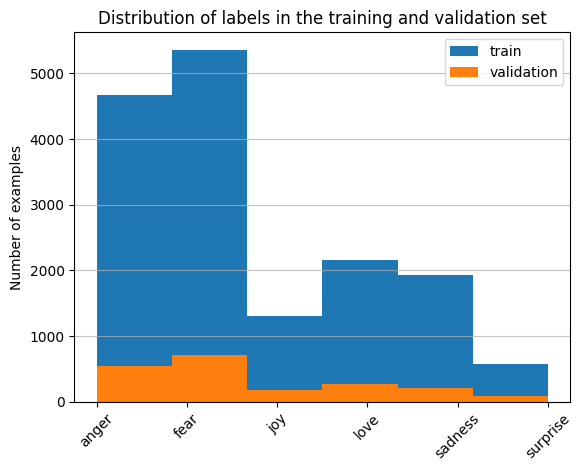

In [5]:
# plot the distribution of the labels in the training set vs the validation set
import matplotlib.pyplot as plt

# get the labels from the training set
train_labels = [example['label'] for example in emotion_dataset['train']]
# get the labels from the validation set
validation_labels = [example['label'] for example in emotion_dataset['validation']]
# get the unique labels
unique_labels = list(set(train_labels))
# get the corresponding names of the label numbers
unique_labels_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# plot the distribution of the labels in the training set
plt.hist(train_labels, bins=len(unique_labels), label='train')
# plot the distribution of the labels in the validation set
plt.hist(validation_labels, bins=len(unique_labels), label='validation')
# draw edges of the bars
plt.grid(axis='y', alpha=0.75)
# set the xticks to the unique labels and their names with the text rotated 45 degrees
plt.xticks(unique_labels, unique_labels_names, rotation=45)
# set the y label
plt.ylabel('Number of examples')
# set the title
plt.title('Distribution of labels in the training and validation set')
# show the legend
plt.legend()
# show the plot
plt.show()

_Student's Comments:_

Since the class sizes aren't equally distributed, accuracy is not the best measure since a model's performance would be biased towards the majority class. So a combination of Precision, Recall, and F1-score should provide a better metric. 

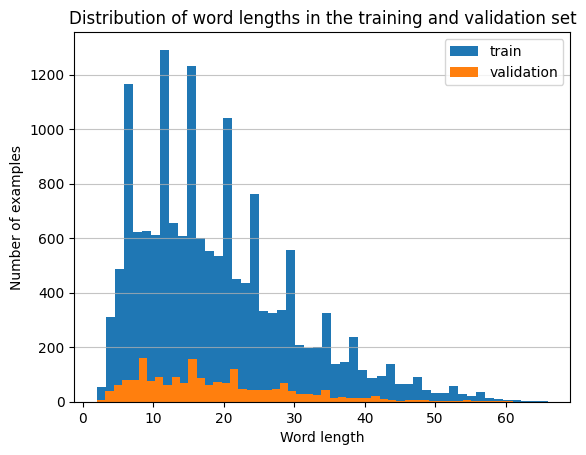

In [6]:
# plot the word length distribution (including punctuation, using nltk tokenize) in the training set vs the validation set
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np

# get the text from the training set
train_text = [example['text'] for example in emotion_dataset['train']]
# get the text from the validation set
validation_text = [example['text'] for example in emotion_dataset['validation']]
# get the word lengths for each example in the training set
train_word_lengths = [len(word_tokenize(text)) for text in train_text]
# get the word lengths for each example in the validation set
validation_word_lengths = [len(word_tokenize(text)) for text in validation_text]

# plot the distribution of the word lengths in the training set
plt.hist(train_word_lengths, bins=50, label='train')
# plot the distribution of the word lengths in the validation set
plt.hist(validation_word_lengths, bins=50, label='validation')
# draw edges of the bars
plt.grid(axis='y', alpha=0.75)
# set the x label
plt.xlabel('Word length')
# set the y label
plt.ylabel('Number of examples')
# set the title
plt.title('Distribution of word lengths in the training and validation set')
# show the legend
plt.legend()
# show the plot
plt.show()

In [29]:
# median word length in the training set
np.median(train_word_lengths)

17.0

In [7]:
from gensim import models

# load the google news negative 300 model
word2vec_model = models.KeyedVectors.load_word2vec_format(
    'models/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [8]:
# check if a word is in the vocabulary of the word2vec model
def is_in_vocabulary(word):
    # if raise KeyError, return False
    try:
        word2vec_model[word] # raise KeyError if word is not in vocabulary
        return True
    except KeyError:
        return False

# test the function
is_in_vocabulary('flibberdoodle')

False

(c) Choose word embeddings and implement loading them.

In [9]:
'''Tokenize a sentence using the word2vec embeddings (loaded earlier) and generate sentence embeddings'''
from nltk.tokenize import RegexpTokenizer, word_tokenize
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

def sentence_embeddings(word2vec_model, sentence):
    # remove all special characters apart from spaces, question marks and exclamation marks
    sentence = re.sub(r'[^a-zA-Z0-9\s\?\!]', '', sentence)
    # tokenize the sentence and convert the sentence to lowercase
    tokenized_sentence = word_tokenize(sentence.lower())

    # get the glove embedding for each word in the sentence
    sentence_embeddings = []
    for word in tokenized_sentence:
        if is_in_vocabulary(word):
            sentence_embeddings.append(word2vec_model[word])
        else:
            sentence_embeddings.append(word2vec_model['unk'])

    # convert the glove embeddings to a numpy array
    sentence_embeddings = np.array(sentence_embeddings)
    # convert the glove embeddings to a tensor
    sentence_embeddings = torch.tensor(sentence_embeddings).float()

    # return the sentence embeddings
    return sentence_embeddings


'''Testing sentence embeddings function'''
entry = 3
print(f"Sentence: '{emotion_dataset['train'][entry]['text']}', with the Label: {emotion_dataset['train'][entry]['label']}, i.e. {unique_labels_names[emotion_dataset['train'][entry]['label']]}")
print(f"Shape of the sentence tensor: {sentence_embeddings(word2vec_model, emotion_dataset['train'][entry]['text']).shape}")


Sentence: 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', with the Label: 2, i.e. joy
Shape of the sentence tensor: torch.Size([18, 300])


In [10]:
from tqdm import tqdm
import pickle

'''Open a file and write the sentence embeddings to it. Note that the embeddings are appended to the file one at a time to not hold all the embeddings in memory at once'''
def write_sentence_embeddings_to_file(word2vec_model, dataset, filename):
    # open the file in append mode
    with open(filename, 'ab') as file:
        # iterate through the dataset
        for example in tqdm(dataset):
            # get the sentence embeddings
            s_embeddings = sentence_embeddings(word2vec_model, example['text'])
            # write the sentence embeddings to the file
            pickle.dump(s_embeddings, file)

# write the sentence embeddings for the training set to a file
write_sentence_embeddings_to_file(word2vec_model, emotion_dataset['train'], 'embeddings/emotion_train_sentence_embeddings.pkl')
# write the sentence embeddings for the validation set to a file
write_sentence_embeddings_to_file(word2vec_model, emotion_dataset['validation'], 'embeddings/emotion_validation_sentence_embeddings.pkl')

100%|██████████| 2000/2000 [00:01<00:00, 1658.47it/s]


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn

# load the train sentence embeddings from the pkl file to a list
with open('embeddings/emotion_train_sentence_embeddings.pkl', 'rb') as f:
    # load the sentence embeddings from the pkl file to a list
    x_train = []
    while True:
        try:
            x_train.append(pickle.load(f))
        except EOFError:
            break

# load the validation sentence embeddings from the pkl file to a list
with open('embeddings/emotion_validation_sentence_embeddings.pkl', 'rb') as f:
    # load the sentence embeddings from the pkl file to a list
    x_validation = []
    while True:
        try:
            x_validation.append(pickle.load(f))
        except EOFError:
            break

# convert the list of train tensors to a tensor by padding the tensors to the maximum length
x_train = rnn.pad_sequence(x_train, batch_first=True, padding_value=0).float()
# convert the list of validation tensors to a tensor by padding the tensors to the maximum length
x_validation = rnn.pad_sequence(x_validation, batch_first=True, padding_value=0).float()
# convert the list of train labels to a tensor
y_train = torch.tensor([example['label'] for example in emotion_dataset['train']]).long()
# convert the list of validation labels to a tensor
y_validation = torch.tensor([example['label'] for example in emotion_dataset['validation']]).long()
# print the shapes
print(f"Shape of the train tensor: {x_train.shape}")
print(f"Shape of the validation tensor: {x_validation.shape}")
print('\n')
print(f"Shape of the train labels tensor: {y_train.shape}")
print(f"Shape of the validation labels tensor: {y_validation.shape}")

Shape of the train tensor: torch.Size([16000, 66, 300])
Shape of the validation tensor: torch.Size([2000, 61, 300])


Shape of the train labels tensor: torch.Size([16000])
Shape of the validation labels tensor: torch.Size([2000])


(d) Design and implement model architecture.

In [30]:
# hyperparameters
batch_size = 32
learning_rate = 0.01
num_epochs = 10
max_sequence_length = 20
num_classes = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# truncate the train and validation tensors to the maximum sequence length
x_train = x_train[:, :max_sequence_length, :]
x_validation = x_validation[:, :max_sequence_length, :]


# create the train and validation datasets
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
validation_dataset = torch.utils.data.TensorDataset(x_validation, y_validation)

# create the train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# create the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# create the model
model = LSTM(input_size=300, hidden_size=128, num_layers=2,
             num_classes=num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


(e) Implement model compilation and training.

In [45]:
# train the model 
from tqdm import tqdm


# train the model
def train(model, train_dataloader, validation_dataloader, num_epochs):
    # iterate through the number of epochs
    for epoch in tqdm(range(num_epochs)):
        # print the epoch number
        print(f"Epoch {epoch+1}/{num_epochs}")
        # set the model to training mode
        model.train()
        # iterate through the train dataloader
        for i, (data, targets) in enumerate(tqdm(train_dataloader)):
            # move the data and targets to the device
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # check accuracy on training & validation set
        check_accuracy(model, train_dataloader, validation_dataloader)

# check the accuracy of the model
def check_accuracy(model, train_dataloader, validation_dataloader):
    # set the model to evaluation mode
    model.eval()

    # check accuracy on training set
    num_correct = 0
    num_samples = 0
    # iterate through the train dataloader
    for i, (data, targets) in enumerate(tqdm(train_dataloader)):
        # move the data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

    # calculate the train accuracy
    train_accuracy = float(num_correct) / float(num_samples)

    # check accuracy on validation set
    num_correct = 0
    num_samples = 0
    # iterate through the validation dataloader
    for i, (data, targets) in enumerate(tqdm(validation_dataloader)):
        # move the data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

    # calculate the validation accuracy
    validation_accuracy = float(num_correct) / float(num_samples)

    # print the train and validation accuracies
    print(f"Train accuracy: {train_accuracy:.2f}, Validation accuracy: {validation_accuracy:.2f}")

In [32]:
# train the model
train(model, train_dataloader, validation_dataloader, num_epochs)

# save the model
torch.save(model.state_dict(), 'models/lstm_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [00:54<08:09, 54.34s/it]

Train accuracy: 0.63, Validation accuracy: 0.63
Epoch 2/10


 20%|██        | 2/10 [01:50<07:24, 55.58s/it]

Train accuracy: 0.85, Validation accuracy: 0.83
Epoch 3/10


 30%|███       | 3/10 [02:51<06:45, 57.91s/it]

Train accuracy: 0.87, Validation accuracy: 0.87
Epoch 4/10


 40%|████      | 4/10 [03:52<05:55, 59.29s/it]

Train accuracy: 0.88, Validation accuracy: 0.87
Epoch 5/10


 50%|█████     | 5/10 [04:57<05:05, 61.11s/it]

Train accuracy: 0.89, Validation accuracy: 0.87
Epoch 6/10


 60%|██████    | 6/10 [06:02<04:10, 62.51s/it]

Train accuracy: 0.90, Validation accuracy: 0.87
Epoch 7/10


 70%|███████   | 7/10 [07:06<03:09, 63.09s/it]

Train accuracy: 0.90, Validation accuracy: 0.87
Epoch 8/10


 80%|████████  | 8/10 [08:12<02:07, 63.96s/it]

Train accuracy: 0.91, Validation accuracy: 0.87
Epoch 9/10


 90%|█████████ | 9/10 [09:27<01:07, 67.31s/it]

Train accuracy: 0.92, Validation accuracy: 0.87
Epoch 10/10


100%|██████████| 10/10 [10:41<00:00, 64.14s/it]

Train accuracy: 0.93, Validation accuracy: 0.87


(f) Experiment and iterate over various hyperparameters(also optimizers, word embeddings, etc.) in order to achieve the best test result possible. Report configuration used to achieve at least 50% categorical accuracy. In case if you find it impossible to achieve 50% threshold - describe in free form what have you tried.

In [36]:
# check the accuracy of the model on the test set

# load the model
model.load_state_dict(torch.load('models/lstm_model.pth'))

# write the sentence embeddings for the test set to a file
write_sentence_embeddings_to_file(
    word2vec_model, emotion_dataset['test'], 'embeddings/emotion_test_sentence_embeddings.pkl')
# load the train sentence embeddings from the pkl file to a list
with open('embeddings/emotion_test_sentence_embeddings.pkl', 'rb') as f:
    # load the sentence embeddings from the pkl file to a list
    x_test = []
    while True:
        try:
            x_test.append(pickle.load(f))
        except EOFError:
            break

# convert the list of test sentences to a tensor
x_test = rnn.pad_sequence(x_test, batch_first=True, padding_value=0).float()
# convert the list of test labels to a tensor
y_test = torch.tensor([example['label'] for example in emotion_dataset['test']]).long()
# create the test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
# create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# check accuracy on test set
check_accuracy(model, test_dataloader, test_dataloader)

100%|██████████| 63/63 [00:04<00:00, 13.42it/s]

Train accuracy: 0.92, Validation accuracy: 0.92


In [40]:
# max sentence length of x_test
print(f"Max sentence length of the test set: {x_test.shape[1]}")

Max sentence length of the test set: 61


_Student's Comments:_

I started training with a max sequence length of 50 which seemed initially like a good idea because of the maximum sentence length being around 66 for the train set and 61 for both the validation and test sets. However, that was a bad idea since the model wasn't learning anything. I had also set the learning rate to 0.001 originally but that wasn't learning fast enough. So I went with a close value to the median sentence length of the train set (17 rounded to 20) and a LR of 0.01 which seems to give a good enough result after 10 epochs.

As noted earlier, the model is probably better off being optimized towards the f1 score due to class size disparity. This can be done in the 'check_accuracy()' function.

In [42]:
# train the model
from tqdm import tqdm
from sklearn.metrics import f1_score

# train the model
def train(model, train_dataloader, validation_dataloader, num_epochs):
    # iterate through the number of epochs
    for epoch in tqdm(range(num_epochs)):
        # print the epoch number
        print(f"Epoch {epoch+1}/{num_epochs}")
        # set the model to training mode
        model.train()
        # iterate through the train dataloader
        for i, (data, targets) in enumerate(tqdm(train_dataloader)):
            # move the data and targets to the device
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # check accuracy on training & validation set
        check_accuracy(model, train_dataloader, validation_dataloader)

# check the accuracy of the model


def check_accuracy(model, train_dataloader, validation_dataloader):
    # check accuracy on training set
    train_targets = []
    train_predictions = []
    # iterate through the train dataloader
    for i, (data, targets) in enumerate(tqdm(train_dataloader)):
        # move the data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        _, predictions = scores.max(1)
        train_predictions.extend(predictions.cpu().numpy())
        train_targets.extend(targets.cpu().numpy())

    # calculate the train f1 score
    train_f1 = f1_score(train_targets, train_predictions, average='macro')

    # check accuracy on validation set
    val_targets = []
    val_predictions = []
    # iterate through the validation dataloader
    for i, (data, targets) in enumerate(tqdm(validation_dataloader)):
        # move the data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        _, predictions = scores.max(1)
        val_predictions.extend(predictions.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

    # calculate the validation f1 score
    val_f1 = f1_score(val_targets, val_predictions, average='macro')

    # print the train and validation f1 scores
    print(f"Train F1 score: {train_f1:.2f}, Validation F1 score: {val_f1:.2f}")


In [43]:
# train the model
train(model, train_dataloader, validation_dataloader, num_epochs)

# save the model
torch.save(model.state_dict(), 'models/lstm_model_f1.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [00:57<08:35, 57.22s/it]

Train F1 score: 0.91, Validation F1 score: 0.85
Epoch 2/10


 20%|██        | 2/10 [01:53<07:35, 56.91s/it]

Train F1 score: 0.92, Validation F1 score: 0.84
Epoch 3/10


 30%|███       | 3/10 [03:03<07:20, 62.91s/it]

Train F1 score: 0.94, Validation F1 score: 0.83
Epoch 4/10


 40%|████      | 4/10 [04:15<06:38, 66.41s/it]

Train F1 score: 0.93, Validation F1 score: 0.83
Epoch 5/10


 50%|█████     | 5/10 [05:25<05:38, 67.71s/it]

Train F1 score: 0.93, Validation F1 score: 0.83
Epoch 6/10


 60%|██████    | 6/10 [06:37<04:36, 69.16s/it]

Train F1 score: 0.95, Validation F1 score: 0.84
Epoch 7/10


 70%|███████   | 7/10 [07:40<03:21, 67.14s/it]

Train F1 score: 0.96, Validation F1 score: 0.84
Epoch 8/10


 80%|████████  | 8/10 [08:54<02:18, 69.41s/it]

Train F1 score: 0.96, Validation F1 score: 0.84
Epoch 9/10


 90%|█████████ | 9/10 [10:08<01:10, 70.69s/it]

Train F1 score: 0.96, Validation F1 score: 0.83
Epoch 10/10


100%|██████████| 10/10 [11:22<00:00, 68.22s/it]

Train F1 score: 0.97, Validation F1 score: 0.84


In [44]:
# check the accuracy of the model on the test set
# Note: the check_accuracy function here is the one on the f1 score

# load the model
model.load_state_dict(torch.load('models/lstm_model_f1.pth'))

# check accuracy on test set
check_accuracy(model, test_dataloader, test_dataloader)

100%|██████████| 63/63 [00:06<00:00,  9.01it/s]

Train F1 score: 0.88, Validation F1 score: 0.88


In [47]:
'''Check the accuracy of the model on the test set
Note: The check_accuracy function here is the one on the accuracy score. So you need to run the code block immediately following (e) Implement model compilation and training. before running this code block'''

# load the model
model.load_state_dict(torch.load('models/lstm_model_f1.pth'))

# check accuracy on test set
check_accuracy(model, test_dataloader, test_dataloader)

100%|██████████| 63/63 [00:05<00:00, 11.11it/s]


Train accuracy: 0.92, Validation accuracy: 0.92


_Student's Comments:_

I need to fine-tune this more. Probably doing a gridsearch using sklearn would be a good idea.

*****************************************************************************************************************************************************
*****************************************************************************************************************************************************

**Task 3 — Text Classification with BERT**

In this task you will build a text classification model through fine-tunning pre-trained transformer model BERT. As in previous task, you will choose one of the provided text classification datasets. You will also get familiar with transformers library.

a) Choose one of the following datasets. Indicate your choice by uncommenting respectful line in code. Datasets are the same as in the previous task.

In [2]:
# load the emotion dataset (dair-ai/emotion) from HuggingFace
from datasets import load_dataset

# load the train and val from the emotion dataset
emotion_dataset = load_dataset('dair-ai/emotion')

# print the first 5 examples
emotion_dataset['train'][:5]

No config specified, defaulting to: emotion/split
Reusing dataset emotion (/home/nishan/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [4]:
emotion_dataset['train'].features


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [5]:
emotion_dataset['train'].features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [23]:
# create a label_dict to map 0-5 to emotion_dataset['train'].features['label'].names
label_dict = {emotion_dataset['train'].features['label'].names[i]:i for i in range(6)}
label_dict

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [7]:
# define the input sentences and the target labels for the train set
X_train = emotion_dataset['train']['text']
y_train = emotion_dataset['train']['label']

# define the input sentences and the target labels for the validation set
X_val = emotion_dataset['validation']['text']
y_val = emotion_dataset['validation']['label']

(b) Choose pre-trained transformer model from Huggingface Hub, and implement code to load pre-trained tokenizer for that model.

In [8]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

# load the BERT tokenizer and encode the train and val sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

(c) Implement batch-tokenization of input data using loaded pre-trained tokenizer. 

In [9]:
# encode the train and val sentences
encoded_train = tokenizer.batch_encode_plus(X_train, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=66, return_tensors='pt', truncation=True)
encoded_val = tokenizer.batch_encode_plus(X_val, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=66, return_tensors='pt', truncation=True)

# attention masks
train_attention_mask = encoded_train['attention_mask']
val_attention_mask = encoded_val['attention_mask']

# convert the train and val sentences to tensors
train_input_ids = encoded_train['input_ids']
val_input_ids = encoded_val['input_ids']

# convert the train and val labels to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

/home/nishan/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
# create the train and val datasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

In [11]:
# load the base BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

(d) Choose hyperparameters for the model training.

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# hyper-parameters
batch_size = 32
epochs = 3
# note the max sequence length is 66 (see the code block above in the encoding of the train and val sentences step)
# also 3 epochs is enough to get a good accuracy score using a pre-trained BERT model

# create the train and val dataloaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)

In [27]:
from sklearn.metrics import f1_score


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        # print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        # print accuracy percentage for each class
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)} = {len(y_preds[y_preds==label])/len(y_true)*100:.2f}%\n')

    # print the overall accuracy
    print(f'Overall Accuracy: {len(preds_flat[preds_flat==labels_flat])}/{len(labels_flat)} = {len(preds_flat[preds_flat==labels_flat])/len(labels_flat)*100:.2f}%')

In [15]:
import random
import numpy as np

seed_val = 42 # the meaning of life the universe and everything
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) # PS: cuda is not available on my machine, this is more for when I do stuff on Colab or on servers

In [16]:
# move the model to the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# print the available device
print(device)

cpu


In [18]:
# evaluate the model on the val set
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                  }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

(e) Compile and train the model. Use prepared training and validation dataset, as well as the optimizer. Use categorical accuracy as metric.

In [ ]:
from tqdm import tqdm

# train the model
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(
        epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                  }

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix(
            {'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(
    ), f'models/bert_emotion_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(train_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


_Student's Comments:_

I repurposed one of my old model architectures I had written for a bert-base model for classifying 5 emotion categories on the tales-emotion dataset (https://github.com/sarnthil/unify-emotion-datasets/tree/master/datasets). Also, I trained it on Colab because my local hardware is not enough to handle this. Took around 20 mins using a Google Colab GPU while mine wasn't able to go through a single epoch even after 70 mins of runtime. Long live GPU's.

(f) Experiment with various hyperparameter and pre-trained models in order to achieve the best possible categorical accuracy on the test set. Report hyperparameters and pre-trained model used to achieve at least 55% accuracy. If you find it impossible to achieve 55% accuracy - describe in free form what have you tried.

In [19]:
# load the model (best model downloaded from my Google Drive)
model.load_state_dict(torch.load('models/bert_emotion_3.model', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# evaluate the model on the val set
_, predictions, true_vals = evaluate(val_dataloader)

In [28]:
# display the accuracy percentage
accuracy_per_class(predictions, true_vals)

Class: sadness
Accuracy: 521/550 = 94.73%

Class: joy
Accuracy: 672/704 = 95.45%

Class: love
Accuracy: 159/178 = 89.33%

Class: anger
Accuracy: 264/275 = 96.00%

Class: fear
Accuracy: 191/212 = 90.09%

Class: surprise
Accuracy: 70/81 = 86.42%

Overall Accuracy: 1877/2000 = 93.85%


In [29]:
# display the f1 score
f1_score_func(predictions, true_vals)

0.9387560937387209

_Student's Note:_

Probably could get better accuracy with model fine-tuning and hyperparameter tuning. However, this looks good enough. Also, the BERT model performs much better in comparison to the LSTM model with the word2vec embeddings as can be seen from the higher scores across both accuracy and F1 and also the accuracy and F1 score being closer to each other.